In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QEDcascPy_positrons import sim_positrons_angle,sim_rr_angle
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
import gp_optimise
import importlib
importlib.reload(gp_optimise)

<module 'gp_optimise' from '/home/cda523/Documents/Positrons/gp_optimise/gp_optimise.py'>

In [2]:
# Sim parameters
Npoints = 10
Nsims = 100
up_scale = 1e3
Nsamples = 1e3

In [3]:
# Expt parameters
Etot = 100 # J
gamma0 = 10e9/0.511e6
gamma_spread = 0.1 * gamma0

# Best compression
duration0 = 25 # fs
waist0 = 2*1.22*0.8 # microns

# Random jitter
t_std = 25e-15
r_std = 10e-6

# Electron energy scaling
gscale = 0.7

In [4]:
# Set up the variables etc
I0 = Etot/((duration0*1e-15)*(waist0*1e-6)**2) * (4*np.log(2)/np.pi)**1.5
a0 = np.sqrt(I0/2.1378e22)

In [21]:
# Define the MC functions to return positron number and rr rate
# Keep the offsets outside the function so I can use the same consistent offsets throughout

z_offset = np.random.default_rng().normal(0, 0.5*t_std*3e8, Nsims)
x_offset = np.random.default_rng().normal(0, r_std, Nsims)
y_offset = np.random.default_rng().normal(0, r_std, Nsims)    
    
def estimate_positrons(params): # params = [Energy split]
    
    positron = np.zeros((Nsims))
    for i in range(Nsims):
        positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.0,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    if np.mean(positron)<=0:
        return -2*np.log10(Nsamples*up_scale),1.0/(np.log10(Nsamples*up_scale)*np.log(10))
    else:
        return np.log10(np.mean(positron)),np.std(positron)/(Nsims*np.mean(positron)*np.log(10))
    
def estimate_rr(params): # params = [Energy split]

    rr = np.zeros(Nsims)
    for i in range(Nsims):
        rr[i] = sim_rr_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    return np.mean(rr),np.std(rr)

#dims = [{'name':'duration','type':'log-uniform','min':5,'max':100}]
dims = [{'name':'Esplit','type':'uniform','min':0,'max':1}]

In [6]:
params = [0.5]

positron = np.zeros((Nsims))
for i in range(Nsims):
    positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.0,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")


Text(0, 0.5, 'Count')

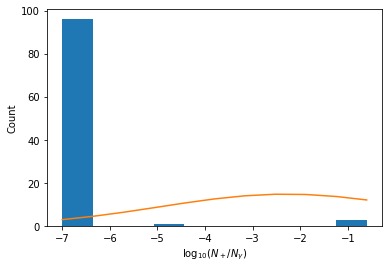

In [11]:
positron[positron==0] = 0.1*(Nsamples*up_scale)**-1
posmean = np.log10(np.mean(positron))
posstd = np.std(positron)/(np.mean(positron)*np.log(10))

npos,bins,patches = plt.hist(np.log10(positron))
ngauss = Nsims/np.sqrt(2*np.pi*posstd**2)*np.exp(-0.5*((bins-posmean)/posstd)**2)
plt.plot(bins,ngauss)
plt.xlabel('log$_{10}(N_+/N_\gamma)$')
plt.ylabel('Count')

In [22]:
kernel = 1*RBF(length_scale_bounds=(1e-1, 1e1))# + WhiteKernel(noise_level_bounds=(1e-2, 1e0))
gpo = gp_optimise.Gp_optimise(estimate_positrons,dims,kernel)

In [23]:
gpo.initialise(Ninitial=10)

1.88**2 * RBF(length_scale=0.165)

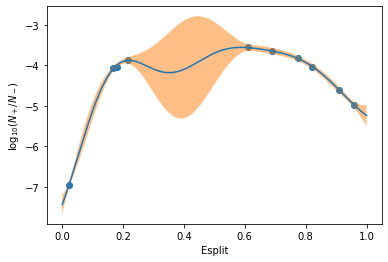

In [24]:
X_test = np.linspace(start=dims[0]['min'], stop=dims[0]['max'], num=1000).reshape(-1, 1)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.scatter(gpo.X,gpo.y)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
#plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log$_{10}(N_+/N_-)$')
gpo.gaussian_process.kernel_

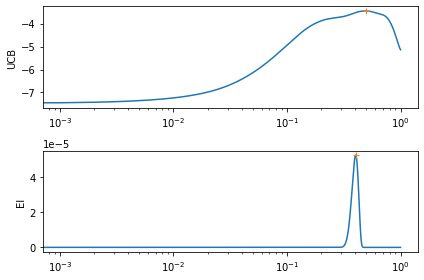

In [29]:
acq_test1 = gpo.acquisition_function(X_test,explore=1,acq_fn='UCB')
acq_test2 = gpo.acquisition_function(X_test,explore=0.1,acq_fn='EI')

nxt1 = gpo.next_acquisition(Nacq=100,explore=1,acq_fn='UCB')
nxt2 = gpo.next_acquisition(Nacq=100,explore=0.1,acq_fn='EI')

plt.subplot(2,1,1)
plt.plot(X_test,acq_test1)
plt.plot(nxt1,gpo.acquisition_function(nxt1,explore=1,acq_fn='UCB'),'+')
plt.xscale('log')
plt.ylabel('UCB')
plt.subplot(2,1,2)
plt.plot(X_test,acq_test2)
plt.plot(nxt2,gpo.acquisition_function(nxt2,explore=0.1,acq_fn='EI'),'+')
plt.xscale('log')
plt.ylabel('EI')
plt.tight_layout()

In [ ]:
N_new = 5
gpo.optimise(N_new,Nacq=100,explore=0.01,acq_fn='EI')

In [ ]:
plt.scatter(gpo.X,gpo.y)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
plt.scatter(gpo.X[-N_new:,0],gpo.y[-N_new:])
#plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log$_{10}(N_+/N_-)$')
plt.ylim([-8,-2])
gpo.next_acquisition(Nacq=10,explore=0.01,acq_fn='EI')